## Семинар 6 "Segmentation"

ФИО: __Костюшко Леонид Игоервич__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch import nn
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc
import torchvision.models as models

from pathlib import Path
from scipy.signal import convolve2d
from scipy.signal import convolve

from PIL import Image
import skimage
from skimage import io

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sys

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process(r'test\images')
t.save(test, TEST_PATH)
train_data = process('training/images', "training/1st_manual/")

In [3]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset, batch_size=4)

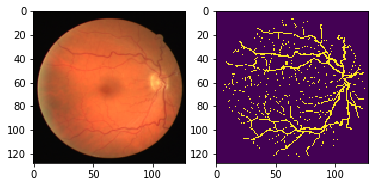

In [4]:
img,mask = dataset[1]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [5]:
bw_image = img.permute(1,2,0).numpy()*0.5+0.5

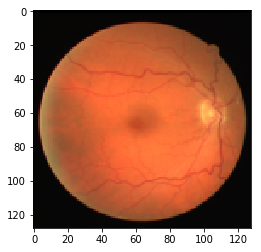

In [6]:
plt.imshow(bw_image)

#### validation

In [7]:
i = 0
train_X = []
test_X = []
for i in range(0, 20):
    if i < 4:
         test_X.append(dataset[i])
    else:
         train_X.append(dataset[i])

      

In [8]:
train_dataloader = DataLoader(train_X, batch_size=4)

test_dataloader = DataLoader(test_X, batch_size=4)

#### loss function dice

In [9]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
       # print(m1)
        #print(type(m1))
       # print(m2.shape)
        
        intersection = (m1 * m2)
        #print(m1.sum(1) + 1)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        #print(score)
        score = 1 - score.sum()/num
        return score

#### trainig dice

In [10]:
dtype=t.FloatTensor

def train(network, epochs, learning_rate, loss, optim=t.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample[0]
                X = X.type(dtype)
                y = sample[1]
                
                
                
                prediction = network(X)
             
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                
  
            train_loss_epochs.append(np.mean(losses))
            
            losses = []    
            for sample in test_dataloader:
                X = sample[0]
                X = X.type(dtype)
                y = sample[1]
                
               
                prediction = network(X)
               
                    
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) Dice: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

#### training cross entropy

In [70]:
#dtype=t.FloatTensor

def train2(network, epochs, learning_rate, optim=t.optim.Adam):
    loss = nn.NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample[0]
                X = X.type(dtype)
                y = sample[1]
                
                
                
                prediction = network(X)
             
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                
  
            train_loss_epochs.append(np.mean(losses))
            
            losses = []    
            for sample in test_dataloader:
                X = sample[0]
                X = X.type(dtype)
                y = sample[1]
                
               
                prediction = network(X)
               
                    
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) Dice: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [94]:
image_size = 128
channels = 3
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(),
                                         nn.Conv2d(3, 2, 3, padding=2), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.LogSoftmax(dim=3))                                
    
    def forward(self, x):
        x = self.conv_layers(x)
        #x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [95]:
model = ConvClassifier(image_size=128)

#### labaratory

In [54]:
image_size = 128
channels = 3
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
                                         nn.Conv2d(3, 16, 3,padding=1),      #down
                                         nn.BatchNorm2d(16),
                                         nn.ReLU(),     
            
                                         nn.Conv2d(16, 16, 3,padding=1), 
                                         nn.BatchNorm2d(16),
                                         nn.ReLU(),
            
                                         nn.MaxPool2d(2),
            
                                         nn.Conv2d(16, 32, 3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
            
                                         nn.Conv2d(32, 32, 3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
            
                                         nn.MaxPool2d(2),
            
                                         nn.Conv2d(32, 64, 3,padding=1), 
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         
                                         nn.ConvTranspose2d(64, 64, 2, stride=2),   #up
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),                            
            
                                         nn.Conv2d(64, 32, 3, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
            
                                         nn.Conv2d(32, 32, 3, padding=1), 
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                
                                         nn.ConvTranspose2d(32, 32, 2, stride=2),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
            
                                         nn.Conv2d(32, 16, 3, padding=1),
                                         nn.BatchNorm2d(16),
                                         nn.ReLU(),
            
                                         nn.Conv2d(16, 16, 3, padding=1), 
                                         nn.BatchNorm2d(16),
                                         nn.ReLU(),
            
                                         nn.Conv2d(16, 1, 3,  padding=1), 
                                         nn.BatchNorm2d(1),
                                         nn.ReLU()
                                        )
                                           
    
    def forward(self, x):
        x = self.conv_layers(x)
        #x = x.view(x.size(0), -1)
      #  x = self.linear_layers(x)
        return x

In [55]:
model = ConvClassifier(image_size=128)

Epoch 5... (Train/Test) Dice: 0.643/0.711

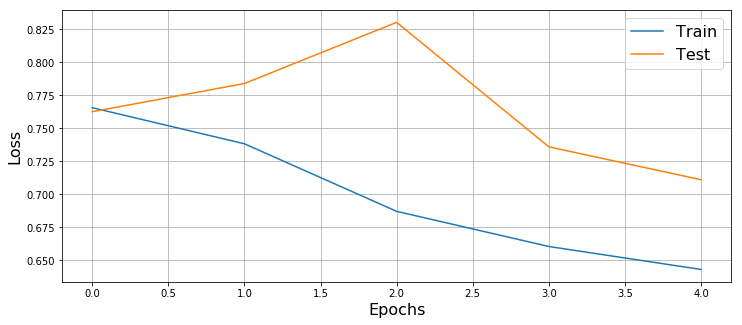

In [56]:
train(model, 6, 0.01, soft_dice_loss)

#### gold standart

In [80]:
image_size = 128
channels = 3
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(),
                                        )
        #self.linear_layers = nn.Sequential(nn.Linear(12150, 200),
          #                                 nn.Dropout(0.8), #50 % probability 
            #                                nn.ReLU(),
              #                              torch.nn.Linear(200, 2*68))
                                           
    
    def forward(self, x):
        x = self.conv_layers(x)
       # x = x.view(x.size(0), -1)
      #  x = self.linear_layers(x)
        return x

In [81]:
model = ConvClassifier(image_size=128)

Epoch 14... (Train/Test) Dice: 0.739/0.743

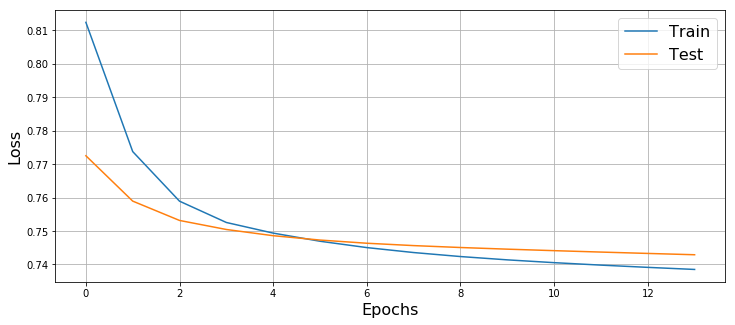

In [82]:
train(model, 15, 0.01, soft_dice_loss)

#### UNet

In [59]:
image_size = 128
channels = 3
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.MaxPool2d(2), 
                                   nn.Conv2d(8, 8, 3, padding=1), 
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(8, 8, 2, stride=2),
                                   nn.ReLU())
        
        self.conv3 = nn.Sequential(nn.Conv2d(16, 1, 3, padding=1), 
                                   nn.ReLU())                   
                                           
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        
        x = t.cat([x2, x1], dim=1)
        
        print("x1= ", x1.size())
        print("x2= ", x2.size())
        print("x= ", x.size())
        
        
        x = self.conv3(x)
        return x

In [60]:
model_unet = ConvClassifier(image_size=128)

x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
Epoch 0... (Train/Test) Dice: 0.887/0.785x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  torch.Size([4, 8, 128, 128])
x=  torch.Size([4, 16, 128, 128])
x1=  torch.Size([4, 8, 128, 128])
x2=  to

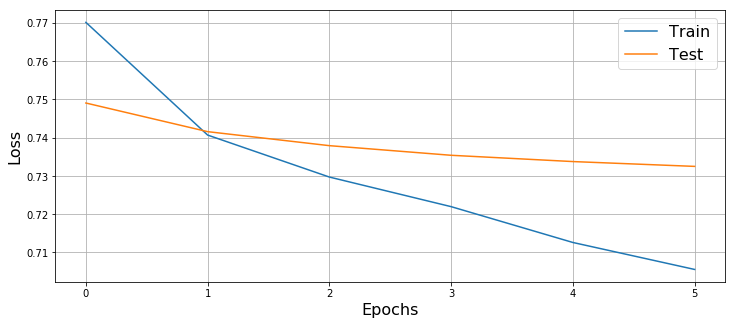

In [61]:
train(model_unet, 15, 0.01, soft_dice_loss)

#### results

In [57]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset, batch_size=1)

In [58]:
os.makedirs("result")
!zip -r result.zip result

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'result'

In [61]:
model = model.eval()
i = 0
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    #tm = (tm > 0.5).astype(int)
    
    
    
    scipy.misc.imsave("result/%s.png" % (ex_id + 1), tm)

D:\Anacondas\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
D:\Anacondas\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


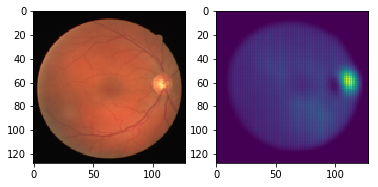

In [62]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)